

---

## Pancaldi Alberto & Federico Santona

---




# Project Overview

This project explores two key quantum algorithms:

1. **Deutsch-Josza Algorithm**: Comparing the performance of classical and quantum approaches to solving the Deutsch-Josza problem.

2. **Grover's Algorithm**: Extending the Grover's search algorithm to scenarios with multiple marked elements.
 

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time

from qiskit import*
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

## Part 1: Deutsch-Josza Problem

### Problem Description
The Deutsch-Josza problem can be summarized as follows:
Given a function $f$, which is either:
  - **Constant**: $f(x)$ is the same for all inputs $x$, or
  - **Balanced**: $f(x)$ returns 0 for half of the inputs and 1 for the other half,
  
Determine whether $f$ is constant or balanced.

For this project, consider a specific class of balanced functions:  $f$ is defined as the XOR of a subset of its input variables. 

For example, $$f(x_0, x_1, x_2, x_3) = x_1 \oplus x_2 \oplus x_3$$Such function s can be represented using a binary array $L = [0, 1, 1, 1]$, where 1 indicates that a variable is included in the XOR operation. For example, $L = [1, 1, 1, 1, 0, 0, 0, 1]$ represents: 
$$f_L(x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7) = x_0 \oplus x_1 \oplus x_2 \oplus x_3 \oplus x_7.$$

This function is denoted as $f_L$
  

### Classical Approach

1. Choose a value of $n$, the number of input variables.
2. Randomly select a constant $c \in \{0, 1\}$ and a binary array $L = [l_0, l_1, \dots, l_{n-1}]$.
3. Define a function
```python
def functionDJ(c, L, x):
```
- If $c = 0$, the function should return 0 for all $x$ (constant function).  
- If $c = 1$, the function should compute $f_L(x)$, the XOR of the variables indicated by $L$.
  

In [36]:
def functionDJ(c, L, x):  
    """
    Implements the Deutsch-Josza function.
    
    Inputs:
        c (int): A constant, either 0 or 1.
        L (array): A binary array indicating which variables to include in the XOR operation.
        x (array): The input variables.

    Outputs:
        int: Either 0 or the XOR of the variables indicated by L.
    """
    if len(L) != len(x):
        raise ValueError("Parameters 'L' and 'x' must have the same length.")
    if c == 0:
        # Return 0 for constant function
        return 0
    elif c == 1:
        # Compute XOR of variables indicated by L
        xor_result = 0
        for i in range(len(L)):
            if L[i] == 1:
                xor_result ^= x[i]   # XOR operation
        return xor_result
    else:
        raise ValueError("Parameter 'c' must be either 0 or 1.")

Tasks:
1. Implement a classical algorithm that, given $c$ and $L$, determines whether the function $functionDJ$ is constant or balanced.
2. Measure the execution time of the algorithm for various values of $n$ and random choices of $c$ and $L$.
3. Plot a graph of execution time against $n$.
4. Identify the values of $n$ for which the computation becomes infeasible on your system.
  
  

In [37]:
def is_constant_or_balanced(c, L):
    """
    Determines if functionDJ is constant or balanced for given c and L.
    
    Inputs:
        c (int): A constant, either 0 or 1.
        L (array): A binary array indicating which variables to include in the XOR operation.

    Outputs:
        str: "constant" or "balanced".
    """
    n = len(L)  # Number of input variables
    x_all = [np.random.randint(0, 2, n) for _ in range(2**n)]  # Generate all the 2^n possible inputs 
    outputs = [functionDJ(c, L, x) for x in x_all]
    if all(o == outputs[0] for o in outputs):
        return "constant"
    else:
        return "balanced"

In [38]:
def measure_execution_time_classic(n_max):
    """
    Measures the execution time of is_constant_or_balanced for different n values.

    Inputs:
        n_max (int): The maximum number of input variables to consider.

    Outputs:
        times (list): The execution times for each n value.
        infeasible_n (int): The first n where computation becomes infeasible.
    """
    times = []  # list to store execution times for each n
    infeasible_n = -1  # The first n where computation becomes infeasible

    for n in range(1, n_max + 1):
        L = np.random.randint(0, 2, n)  # Random binary array L
        c = np.random.choice([0, 1])  # Random choice for c
        start_time = time.time()
        try:
            is_constant_or_balanced(c, L)
            execution_time = time.time() - start_time
            times.append(execution_time)
        except MemoryError:
            infeasible_n = n 
            break
    return times, infeasible_n

In [39]:
def plot_execution_time(times):
    n_values = list(range(1, len(times) + 1))
    plt.plot(n_values, times, marker='o', linestyle='-', label="Execution time")
    plt.title("Execution Time vs Number of Variables (n)")
    plt.xlabel("Number of Variables (n)")
    plt.ylabel("Execution Time (s)")
    plt.grid()
    plt.legend()
    plt.show()

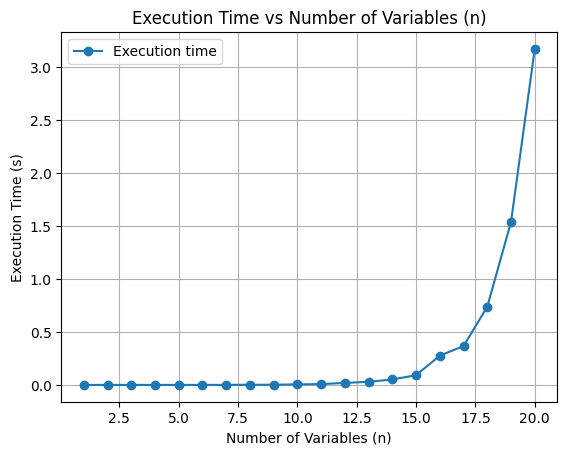

All computations completed successfully for n_max = 20


In [40]:
# Set the number of input variables n:
n_max = 20 
times_classic, infeasible_n = measure_execution_time_classic(n_max)

# Plot of execution time vs n
plot_execution_time(times_classic)

# Print infeasibility point
if infeasible_n != -1:
    print(f"Computation becomes infeasible for n >= {infeasible_n}")
else:
    print("All computations completed successfully for n_max =", n_max)

### Quantum Approach
1. Implement an oracle that generates the circuit for the unitary gate $U_{f_L}$, defined as:$$U_f(|x\rangle |y\rangle) = |x\rangle |y \oplus f_L(x)\rangle$$
2. If $c = 0$, the oracle should return the identity circuit.
3. If $c = 1$, the oracle should return the circuit for $U_{f_L}$.
  

In [41]:
def oracle(c, L, circuit):
    """
    Generates a quantum oracle for the Deutsch-Josza algorithm.
    U_f|x>|y> = |x>|y⊕f(x)>

    Inputs:
        c (int): A constant, either 0 or 1.
        L (array): A binary array indicating which input qubits affect the XOR operation.
        circuit (QuantumCircuit): The quantum circuit to which the oracle will be added.

    Outputs:
        Quantum circuit implementing the oracle U_f.
    """
    n = len(L)  # Number of input qubits
    if c == 0:
        # If the function is constant, do nothing (identity gate)
        pass
    elif c == 1:
        # If the function is balanced, add CNOT gates for each qubit in L
        for i in range(n):
            if L[i] == 1:
                circuit.cx(i, n)  # CNOT gate controlled by qubit i and targeting the output qubit
    else:
        raise ValueError("Parameter 'c' must be either 0 (constant) or 1 (balanced).")
    return circuit

### Execution on Quantum Hardware
Use the oracle and the Deutsch-Josza algorithm on a real quantum backend to determine if the function is constant or balanced. Measure the execution time and compare it with the classical approach.
  

In [42]:
def deutsch_jozsa_algorithm(c, L):
    """
    Implements the Deutsch-Josza algorithm.

    Inputs:
        c (int): A constant, either 0 or 1.
        L (array): A binary array indicating which input qubits affect the XOR operation.

    Outputs:
        Quantum circuit implementing the oracle U_f.
    """
    n = len(L)  # Number of input qubits

    # Definition of the quantum circuit with n+1 qubits 
    qr = QuantumRegister(n + 1)           # Quantum register 
    cr = ClassicalRegister(n)             # Classical register
    circuit = QuantumCircuit(qr, cr)

    circuit.x(n)
    circuit.h(range(n+1))  
    circuit.barrier()
    oracle(c, L, circuit)
    circuit.barrier()
    circuit.h(range(n))
    circuit.measure(range(n), range(n))

    # Use the Sampler to get the result of the measurement
    result = SamplerV2().run([circuit]).result()
    counts = result[0].join_data().get_counts()  

    zero_state = "0" * n   # |0...0⟩ state
    zero_count = counts.get(zero_state, 0)  
    total_counts = sum(counts.values())

    # If |0...0⟩ has nearly 100% counts, function is constant, otherwise it is balanced
    if zero_count / total_counts > 0.9:
        result_str = "constant"
    else:
        result_str = "balanced"

    return circuit, result_str

Output of Deutsch-Josza algorithm:
The function is: balanced


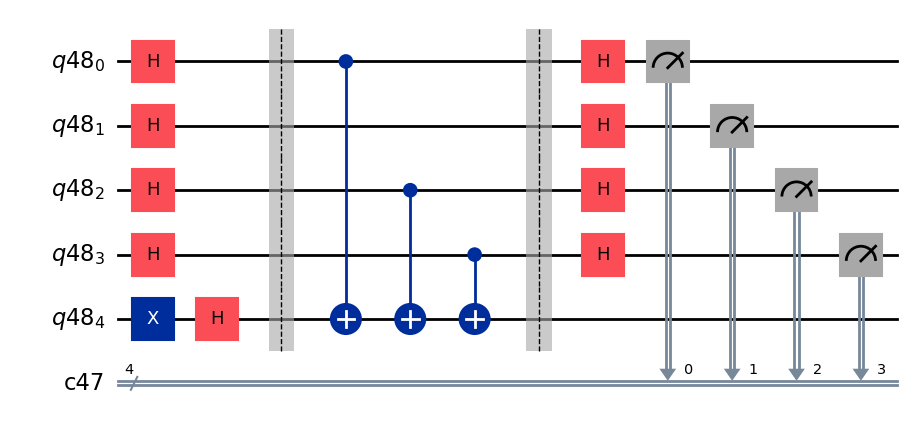

In [43]:
# Define oracle parameters:
c = 1  # c=1 for a balanced function, c=0 for a constant function
L = [1, 0, 1, 1]  # Binary array indicating which qubits affect the XOR operation

# Run the Deutsch-Josza algorithm
circuit, result = deutsch_jozsa_algorithm(c, L)

# Output the result
print("Output of Deutsch-Josza algorithm:")
print("The function is:", result)

# Draw the circuit
circuit.draw("mpl")

In [44]:
def measure_execution_time_quantum(n_max):
    """
    Measures the execution time of Deutsch-Josza algorithm for different n values.

    Inputs:
        n_max (int): The maximum number of input variables to consider.

    Outputs:
        times (list): The execution times for each n value.
        infeasible_n (int): The first n where computation becomes infeasible.
    """
    times = []  # list to store execution times for each n
    infeasible_n = -1  # The first n where computation becomes infeasible

    for n in range(1, n_max + 1):
        L = np.random.randint(0, 2, n)  # Random binary array L
        c = np.random.choice([0, 1])  # Random choice for c
        start_time = time.time()
        try:
            deutsch_jozsa_algorithm(c, L)
            execution_time = time.time() - start_time
            times.append(execution_time)
        except MemoryError:
            infeasible_n = n 
            break
    return times, infeasible_n

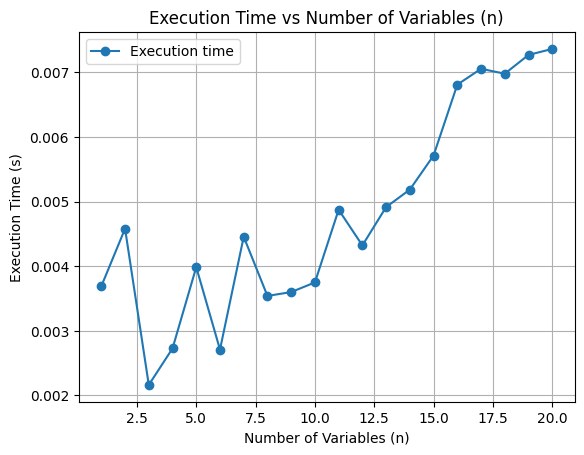

All computations completed successfully for n_max = 20


In [45]:
# Set the number of input variables n:
n_max = 20 
times_quantum, infeasible_n = measure_execution_time_quantum(n_max)

# Plot of execution time vs n
plot_execution_time(times_quantum)

# Print infeasibility point
if infeasible_n != -1:
    print(f"Computation becomes infeasible for n >= {infeasible_n}")
else:
    print("All computations completed successfully for n_max =", n_max)

### Comparison and Analysis
Plot the execution times of the quantum and classical approaches for increasing values of $n$. Highlight the computational advantages of the quantum solution as $n$ grows.
  

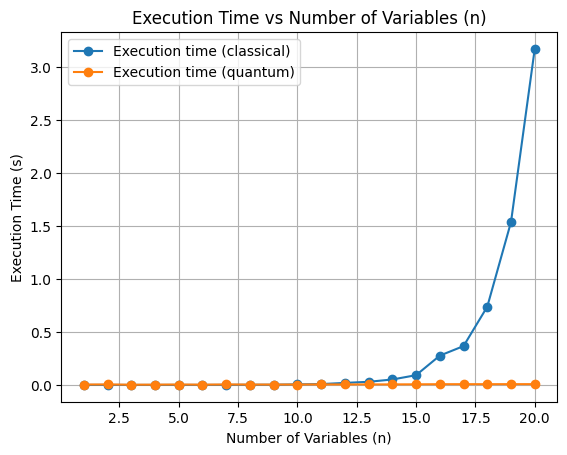

In [46]:
n_values = list(range(1, len(times_classic) + 1))
plt.plot(n_values, times_classic, marker='o', linestyle='-', label="Execution time (classical)")
plt.plot(n_values, times_quantum, marker='o', linestyle='-', label="Execution time (quantum)")
plt.title("Execution Time vs Number of Variables (n)")
plt.xlabel("Number of Variables (n)")
plt.ylabel("Execution Time (s)")
plt.grid()
plt.legend()
plt.show()

## Part 2: Grover's Algorithm
### Tasks
1. Implement Grover's algorithm for a 6-qubit system with two marked elements.
2. Determine the optimal number of iterations.
3. Execute the algorithm on a real quantum backend and plot a histogram of the results.
  